# Setup Environment

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

# set kaggle json dir
import os
#Personal example
os.environ['KAGGLE_CONFIG_DIR'] = "/project/.kaggle"
os.environ['KAGGLE_USERNAME'] = "spregler"
os.environ['KAGGLE_KEY'] = "XXXX"

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [1]:
%cd ..
%mkdir /project/
%cd /project

/
/project


In [5]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

100% 777M/779M [00:16<00:00, 71.7MB/s]
100% 779M/779M [00:16<00:00, 50.9MB/s]


In [0]:
!unzip plant-pathology-2020-fgvc7

In [8]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 18kB/s 
     |████████████████████████████████| 4.0MB 39.5MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
!pip install neptune-client
!pip install neptune-contrib
!pip install neptune-contrib[monitoring]

# Import Dependencies & Extract Data

In [9]:
import neptune

neptune.init(
    api_token='XXXX',
    project_qualified_name='spregler/fastai'
)

Project(spregler/fastai)

In [141]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May 28 03:24:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    36W / 250W |   3593MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [142]:
import os 
from pathlib import Path

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import fastai
import fastai.vision
from fastai import *
from fastai.vision import *
from fastai.vision import learner
from sklearn.metrics import *

import pandas as pd
import numpy as np

root_dir = Path("/project/") # Local path object in colab
train_df = pd.read_csv('/project/train.csv')
test_df = pd.read_csv("/project/test.csv")
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [197]:
test_data = ImageList.from_df(test_df, root_dir, folder='images', suffix='.jpg')
test_data

ImageList (1821 items)
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
Path: /project

# Transform Data w/ Helper Function

In [0]:
def transformPipeline(df):
  # Creates a class column and assign it to the index which produces the max value for each row
  df['class'] = np.argmax(train_df.loc[:, ['healthy','multiple_diseases','rust','scab']].values, axis=1)
  # Drops columnns that are no longer of use
  df.drop(columns=['healthy','multiple_diseases','rust','scab'], inplace=True)
  print("Transformed df: ")
  print(train_df.head())


In [145]:
transformPipeline(train_df)

Transformed df: 
  image_id  class
0  Train_0      3
1  Train_1      1
2  Train_2      0
3  Train_3      2
4  Train_4      0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6eea19390>]], dtype=object)

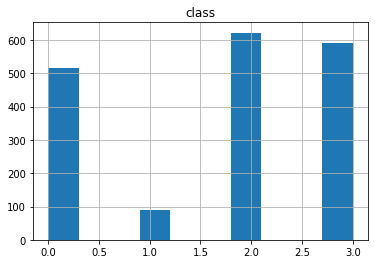

In [146]:
train_df.hist() # we have imbalanced data!

In [147]:
train_df['class'].value_counts(sort=False)

0    516
1     91
2    622
3    592
Name: class, dtype: int64

In [0]:
# multi_diseases = train_df[train_df['class' ] == 1 ]

In [0]:
# df = train_df[train_df['class' ] == True ]
# temp1 = df.copy()
# temp2 = df.copy()
# temp3 = df.copy()
# temp4 = df.copy()
# temp5 = df.copy()

# multi_diseases = pd.concat([temp1,temp2,temp3,temp4,temp5])
# multi_diseases

In [0]:
# balanced_df = pd.concat([train_df,multi_diseases])
# balanced_df['class'].value_counts(sort=False)

In [0]:
# balanced_df.hist() # We have more balanced data!

# Create ImageList Object Using DataBlocks API

In [0]:
seed = np.random.seed(42)
src = (ImageList.from_df(train_df, root_dir, folder='images', suffix='.jpg')
       .split_by_rand_pct(seed=seed)
       .label_from_df())

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.5, max_rotate=90.0)

data = (src.transform(tfms, size=256)
      .databunch(bs=64)
      .normalize(imagenet_stats))

In [153]:
data

ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
3,1,0,2,0
Path: /project;

Valid: LabelList (364 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
2,0,0,2,0
Path: /project;

Test: None

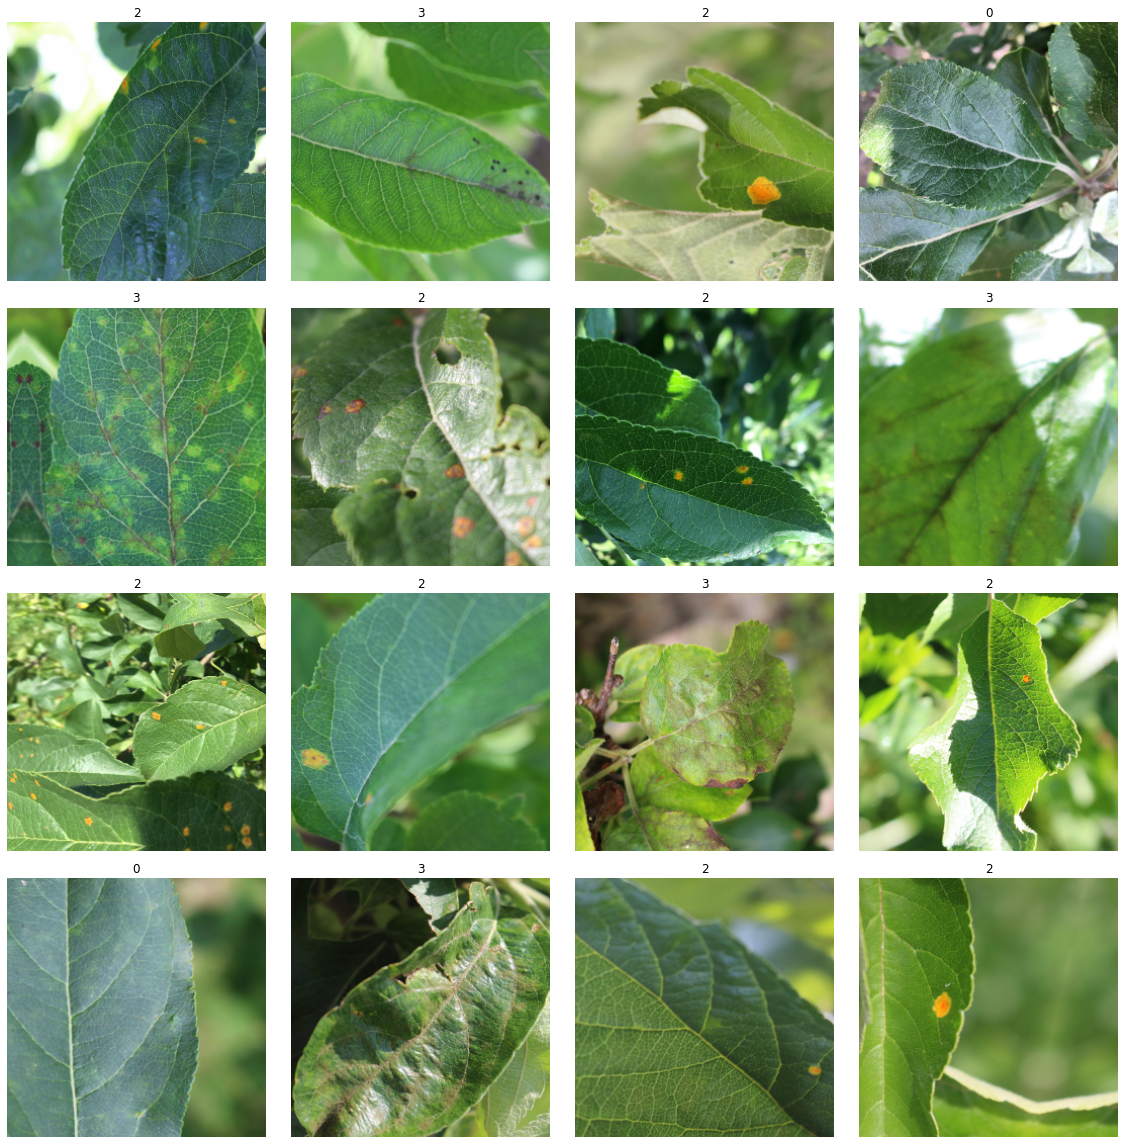

In [154]:
data.show_batch(rows=4)

# Training

In [0]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy(), target.cpu().numpy()
    return roc_auc_score(input, target)

@dataclass
class AUC(Callback):
    clas:int=1
    _order = -30
    
    def __init__(self, clas, **kwargs):
        super().__init__()
        self.clas = clas
        self.temp_list = ["healthy", "multiple_diseases", "rust", "scab"]
        self.name = "auc_" + str(self.temp_list[self.clas])
        self.roc = 0
    
    def on_epoch_begin(self, **kwargs):
        self.output, self.target = [], []
    
    def on_batch_end(self, last_output, last_target, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            considered_clas = self.clas
            indexes = (target == considered_clas)
            target_for_roc = torch.zeros(target.size())
            target_for_roc[indexes] = 1
            probs = F.softmax(output, dim = 1)
            pfinal = probs[:, considered_clas]
            self.metric = auroc_score(target_for_roc, pfinal)
            self.roc = self.metric
        return add_metrics(last_metrics, self.metric)

In [0]:
class MeanAUC(Callback):
    _order = -20
    
    def __init__(self, auc0, auc1, auc2, auc3):
        super().__init__()
        self.name = "Mean AUC"
        self.auc0 = auc0
        self.auc1 = auc1
        self.auc2 = auc2
        self.auc3 = auc3
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, (self.auc0.roc + self.auc1.roc + self.auc2.roc + self.auc3.roc) / 4)

The following cell integrates the Neptune API with the Fastai framework. Neptune is an experiment management tool that is helpful for keeping track of experiments and logging metrics.

In [157]:
from fastai.callbacks import *
from neptunecontrib.monitoring.fastai import NeptuneMonitor

auc0 = AUC(clas=0)
auc1 = AUC(clas=1)
auc2 = AUC(clas=2)
auc3 = AUC(clas=3)
meanauc = MeanAUC(auc0, auc1, auc2, auc3)

arch = models.resnet50 # define model

with neptune.create_experiment(params={'lr':1e-3}):
  learn = cnn_learner(data, arch, metrics=[accuracy , error_rate, auc0, auc1, auc2, auc3, meanauc],
                        callback_fns=[NeptuneMonitor], wd=1e-3).to_fp32()
  learn.fit_one_cycle(5, 1e-3) # fit to our data

https://ui.neptune.ai/spregler/fastai/e/FAS-79


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,1.472645,0.555381,0.837912,0.162088,0.969773,0.715478,0.974454,0.961451,0.905289,02:16
1,0.958011,0.481530,0.848901,0.151099,0.978447,0.879416,0.988798,0.975490,0.955538,02:15
2,0.704246,0.443606,0.859890,0.140110,0.973258,0.900289,0.989925,0.974723,0.959549,02:15
3,0.562649,0.377925,0.873626,0.126374,0.980568,0.921002,0.990779,0.979392,0.967935,02:15
4,0.477601,0.383206,0.881868,0.118132,0.981856,0.918112,0.990779,0.979659,0.967601,02:14


In [0]:
learn.save('resnet-stage1')

In [0]:
learn.unfreeze()

https://ui.neptune.ai/spregler/fastai/e/FAS-80


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-08


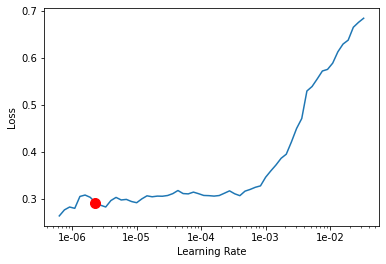

In [160]:
with neptune.create_experiment():
  learn.lr_find() # find optimal lr
  learn.recorder.plot(suggestion=True)

In [161]:
with neptune.create_experiment():
  learn.fit_one_cycle(15,slice(1e-5, 1e-3) )

https://ui.neptune.ai/spregler/fastai/e/FAS-81


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,0.319160,0.352694,0.895604,0.104396,0.983409,0.927103,0.990779,0.981059,0.970588,02:16
1,0.298508,0.305998,0.906593,0.093407,0.987235,0.951349,0.991393,0.987728,0.979426,02:16
2,0.288678,0.361726,0.906593,0.093407,0.986212,0.911047,0.991735,0.989629,0.969656,02:18
3,0.278821,0.370747,0.917582,0.082418,0.988958,0.938343,0.994706,0.986261,0.977067,02:14
4,0.279140,0.247324,0.939560,0.060440,0.986591,0.954078,0.997199,0.988929,0.981699,02:16
5,0.271203,0.247894,0.942308,0.057692,0.994432,0.946532,0.997097,0.990930,0.982248,02:16
6,0.235699,0.243186,0.945055,0.054945,0.990720,0.958414,0.997746,0.990630,0.984377,02:14
7,0.205311,0.224522,0.945055,0.054945,0.993068,0.967566,0.997029,0.993297,0.987740,02:15
8,0.185667,0.218176,0.947802,0.052198,0.995038,0.973186,0.997336,0.993231,0.989698,02:15
9,0.161001,0.192364,0.956044,0.043956,0.992121,0.964836,0.998497,0.992797,0.987063,02:16


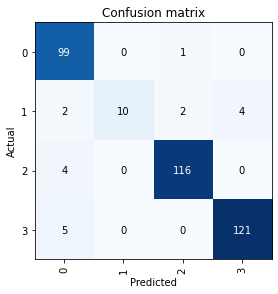

In [163]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn.save('resnet-stage2')
learn.load('resnet-stage2')
learn.export()

In [0]:
preds, y = learn.get_preds(test_data)

In [187]:
preds_np = preds.numpy()
pred_df = pd.DataFrame(preds_np)
pred_df.shape

(1457, 4)

In [188]:
pred_df.head()

,0,1,2,3
0,1.432824e-06,2.744246e-08,1.199954e-09,9.999986e-01
1,1.353107e-03,7.817404e-01,2.120605e-01,4.845963e-03
2,9.999663e-01,2.156469e-06,2.952170e-05,2.011793e-06
3,1.478567e-09,6.906837e-06,9.999931e-01,1.909917e-10
4,9.999033e-01,5.902116e-06,8.994346e-05,6.822142e-07


In [189]:
sample_df.shape

(1821, 5)

In [0]:
sample_df = pd.read_csv(root_dir/'sample_submission.csv')
sample_df.iloc[:,1:] = preds.numpy()
sample_df.to_csv('submission.csv', index=False)

# Conclusion:
The end model was able to acheive a score of .949 on the kaggle challenge public learderboard: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/leaderboard

# References:
* shoutout to @anurag25 github: https://github.com/anurag25/shared_notebooks/blob/master/plant_pathology2.ipynb 
  * for the helpful AUC and MeanAUC Classes that allowed me to track important metrics with fastai

# The Origninal Paper:
Can be found: https://arxiv.org/abs/2004.11958